# Project for DTU course 02456 Deep Learning
## Written by Kilian Conde-Frieboes (s190224)
### Introduction

The project will try to correlate peptide structure to measured biological data, in this case binding data to one or two receptors. The peptides are 31 amino acids long, each amino acid will be described by 5 z-scales (New Chemical Descriptors Relevant for the Design of Biologically Active Peptides. A Multivariate Characterization of 87 Amino Acids Maria Sandberg, Lennart Eriksson, Jörgen Jonsson, Michael Sjöström and Svante Wold _J.Med.Chem._ __1998__, _41_, 2481-2491). The z-scales originate in a PCA analysis and are the projections onto the main componenets. The different components can be interpreted as certain biophysical properties, e.g. the first component correalates heavy with lipophilicity. A large negative loading indicates a lipophilic amino acids, e.g. $z1=-4.22$ for the amino acid Phenylalanine. So each peptide is represented by 5x31 numbers. The network will use a CNN as main unit and the data will be read in as a five-layered 1D array.

Some peptide processing utilities have been written earlier by KCF and are stored in KCFutil.

In [1]:
import KCFutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection   import train_test_split
import time

np.random.seed(2456)
torch.manual_seed(2456)

In [2]:
# Shameless stolen from exercise 6
use_cuda = torch.cuda.is_available()

print("Running GPU.") if use_cuda else print("No GPU available.")
def get_variable(x):
    if use_cuda:
        return x.cuda()
    return x



Running GPU.


Data are read in from a .csv file into a pandas data frame. Selected columns are copied over into a new dataframe (sequence, activity1, activity2) and the dataframes are concatenated into a larger dataframe ('combi').

In [3]:
lib1=pd.read_csv(filepath_or_buffer =r'Results Lib1.csv',header=0, index_col=False, sep=',')
lib2=pd.read_csv(filepath_or_buffer =r'Results Lib2.csv',header=0, index_col=False, sep=',')
lib3=pd.read_csv(filepath_or_buffer =r'Results Lib3.csv',header=0, index_col=False, sep=',')

lib1_red=pd.DataFrame()
lib2_red=pd.DataFrame()
lib3_red=pd.DataFrame()

lib1_red['Sequence']=lib1['Sequence']
lib2_red['Sequence']=lib2['Sequence']
lib3_red['Sequence']=lib3['Sequence']

lib1_red['Receptor_1']=lib1['Receptor_1']
lib2_red['Receptor_1']=lib2['Receptor_1']
lib3_red['Receptor_1']=lib3['Receptor_1']

lib1_red['Receptor_2']=lib1['Receptor_2']
lib2_red['Receptor_2']=lib2['Receptor_2']
lib3_red['Receptor_2']=lib3['Receptor_2']

lib1_red=lib1_red.dropna()
lib2_red=lib2_red.dropna()
lib3_red=lib3_red.dropna()

The binding affinities were preprocessed in Excel and the numbers are relative to a control peptide. The quantity used is the shift on the binding curve relative to control on a log scale. The picture below may help.
<img src="image 1.PNG">

In [4]:
combi=pd.concat([lib1_red,lib2_red,lib3_red], axis=0,ignore_index=True)
combi.to_csv('combi.csv')

Lets take a look at the data.

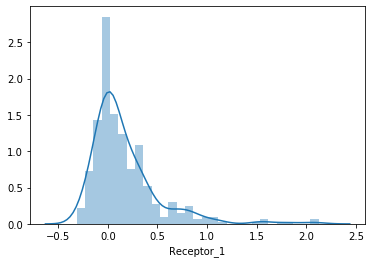

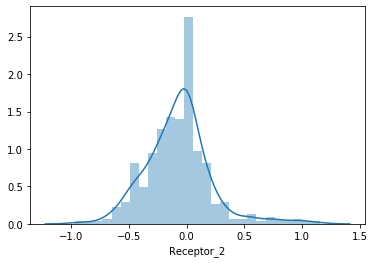

In [5]:
sns.distplot(combi['Receptor_1'])
plt.show()
sns.distplot(combi['Receptor_2'])
plt.show()

An array for the features is created storing the 31x5 zscales for each peptide.


In [6]:
x=torch.empty((len(combi),31,5))
y=torch.empty((len(combi),2))


for i, row in  combi.iterrows():
    pep=KCFutil.peptide(row['Sequence'])
    x[i]=torch.FloatTensor(pep.zscale5mat)
    y[i]=torch.FloatTensor((row['Receptor_1'],row['Receptor_2']))

In [7]:
x=get_variable(x)
y=get_variable(y)

In [8]:
train_size = int(0.9 * len(x))
test_size = len(x) - train_size
train_data, test_data = random_split(TensorDataset(x,y), [train_size, test_size])

Here I will define a basic network.

In [90]:
# in_channels is 5 for the 5 zscales
np.random.seed(42)
torch.manual_seed(42)

out_channel= 15 #lets start with 5
kernel_size=11
conv_stride=1
conv_pad=kernel_size//2
conv_out=out_channel*31

hiddensize= 50 #lets start with 5
layers=2

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=5,
                             out_channels=out_channel,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        torch.nn.init.xavier_uniform_(self.conv.weight)
        self.conv_drop = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size =5,hidden_size=hiddensize,num_layers =layers, bidirectional = True)
        
        self.fc1_features=conv_out+hiddensize*2*layers
        self.ffnn_drop=nn.Dropout(0.5)
        
        self.ffnn1=nn.Linear(in_features=self.fc1_features,
                            out_features=100,
                            bias=False)
        torch.nn.init.xavier_uniform_(self.ffnn1.weight)
        
        
        self.l_out = nn.Linear(in_features=100,
                            out_features=2,
                            bias=False)
        torch.nn.init.xavier_uniform_(self.l_out.weight)
        
    def forward(self, x):
      
        x = x.transpose(0,1)
        #input shape is (seq length, batch size, features)
        _, (h_n, c_n) = self.lstm(x)
        out = h_n.transpose(0,1)
        out = out.reshape(-1,hiddensize*2*layers)
        LSTMout=out
        x = x.transpose(0,1)
        
        
        x=x.transpose(2,1)
        out=self.conv(x)
        out=torch.relu(out)
        out=self.conv_drop(out)
        out = out.view(-1,conv_out)
        
        CNNout=out
        out=[]
        out.append(LSTMout)
        out.append(CNNout)
        out = torch.cat(out, dim=1)
        
        out=self.ffnn1(out)
        out=torch.relu(out)
#        out=self.ffnn_drop(out)
        
        
        
        out=self.l_out(out)
        return out
net = Net()
if use_cuda:
    net.cuda()
print(net)   

Net(
  (conv): Conv1d(5, 15, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv_drop): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(5, 50, num_layers=2, bidirectional=True)
  (ffnn_drop): Dropout(p=0.5, inplace=False)
  (ffnn1): Linear(in_features=665, out_features=100, bias=False)
  (l_out): Linear(in_features=100, out_features=2, bias=False)
)


Now test it.

In [91]:
Y_pre=net(x)
print(x[0])
print(Y_pre[0])

tensor([[ 2.3900, -1.0700,  1.1500, -1.3900,  0.6700],
        [ 3.5200,  2.5000, -3.5000,  1.9900, -0.1700],
        [ 0.7500, -2.1800, -1.1200, -1.4600, -0.4000],
        [ 2.4700,  1.9500,  0.2600,  3.9000,  0.0900],
        [ 3.5200,  2.5000, -3.5000,  1.9900, -0.1700],
        [ 2.4700,  1.9500,  0.2600,  3.9000,  0.0900],
        [ 2.3900, -1.0700,  1.1500, -1.3900,  0.6700],
        [-2.8500, -0.2200,  0.4700,  1.9400, -0.9800],
        [ 3.1100,  0.2600, -0.1100, -3.0400, -0.2500],
        [-3.8900, -1.7300, -1.7100, -0.8400,  0.2600],
        [ 3.5200,  2.5000, -3.5000,  1.9900, -0.1700],
        [ 0.7500, -2.1800, -1.1200, -1.4600, -0.4000],
        [-1.6600,  0.2700,  1.8400,  0.7000,  2.0000],
        [ 3.9800,  0.9300,  1.9300, -2.4600,  0.7500],
        [-3.8900, -1.7300, -1.7100, -0.8400,  0.2600],
        [ 3.0500,  1.6200,  1.0400, -1.1500,  1.6100],
        [-1.6600,  0.2700,  1.8400,  0.7000,  2.0000],
        [ 0.2400, -2.3200,  0.6000, -0.1400,  1.3000],
        [-

In [92]:
lr = 0.001
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
max_iter = 2000

Split the data into test and train

In [93]:
x_train, y_train=train_data[:]
x_test, y_test=test_data[:]


Train loop here.

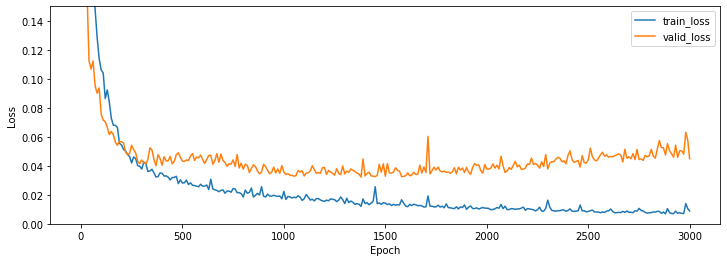

Saved at epoch 1380
epoch: 2999 	train loss: 0.0089 (-0.0015)	val loss: 0.0449 (-0.0127)	time used: 154.4s
Minimum Validation loss: 0.0322 in epoch 1380.
Done (for now)!


In [94]:
start=time.time()
train_loss_=[]
val_loss_=[]
epoch_=[]
min_val=100000
save_epoch=0

net.train()
for epoch in range(max_iter):
    y_pre = net(x_train)
    train_loss = criterion(y_pre,y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if epoch%10==0:
        net.eval()
        y_val=net(x_test)
        val_loss=criterion(y_val,y_test)
        val_loss_.append(val_loss)
        net.train()
        train_loss_.append(train_loss)
        epoch_.append(epoch)
        
        fig = plt.figure(figsize=(12,4))
        plt.plot(epoch_, train_loss_, label='train_loss')
        plt.plot(epoch_, val_loss_, label='valid_loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim([0,0.15])
        plt.show()
        min_val=min(min_val,val_loss_[-1].item())
        if min_val==val_loss_[-1].item():
            save_epoch=epoch
            path=r'.\combimodel'
            torch.save(net.state_dict(), path)
        print('Saved at epoch {}'.format(save_epoch))    
        if len(train_loss_)>1:
            print ('epoch: {} \ttrain loss: {:.4f} ({:.4f})\tval loss: {:.4f} ({:.4f})\ttime used: {:.1f}s'.format(epoch,train_loss_[-1],train_loss_[-1]-train_loss_[-2]
                                                                                                           ,val_loss_[-1],val_loss_[-1]-val_loss_[-2],time.time()-start))
        else:
            print ('epoch: {} \ttrain loss: {:.4f}\tval loss: {:.4f}\ttime used: {:.1f}s'.format(epoch,train_loss_[-1],val_loss_[-1],time.time()-start))
        clear_output(wait=True)
        
        
#    if epoch>5000:
#        if ((val_loss_[-1]-val_loss_[-2])>0) and ((val_loss_[-2]-val_loss_[-3])>0):
#            break #break if overfitting starts
net.eval()
y_val=net(x_test)
val_loss=criterion(y_val,y_test)
val_loss_.append(val_loss)
net.train()
train_loss_.append(train_loss)
epoch_.append(epoch)
fig = plt.figure(figsize=(12,4))
plt.plot(epoch_, train_loss_, label='train_loss')
plt.plot(epoch_, val_loss_, label='valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.15])
plt.legend()
plt.savefig('CombiTrainloss.png')
plt.show()
print('Saved at epoch {}'.format(save_epoch))
print ('epoch: {} \ttrain loss: {:.4f} ({:.4f})\tval loss: {:.4f} ({:.4f})\ttime used: {:.1f}s'.format(epoch,train_loss_[-1],train_loss_[-1]-train_loss_[-2],val_loss_[-1],val_loss_[-1]-val_loss_[-2],time.time()-start))
min_val=min(val_loss_).item()
min_index=val_loss_.index(min_val)
min_epoch=epoch_[min_index]                                                                                                       
print('Minimum Validation loss: {:.4f} in epoch {}.'.format(min_val,min_epoch))
print('Done (for now)!')   

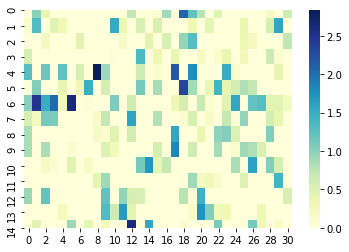

In [95]:
if min_val==val_loss_[-1]:
    path=r'.\combimodel'
    torch.save(net.state_dict(), path)
    print('Saved at last epoch')
checkpoint = torch.load('combimodel')
net.load_state_dict(checkpoint)
y_pre = net(x_train)
y_val=net(x_test)

import seaborn as sns
test=torch.relu(net.conv(x_test.transpose(2,1)))
sns.heatmap(test[0].cpu().detach().numpy(), cmap="YlGnBu")
plt.show()

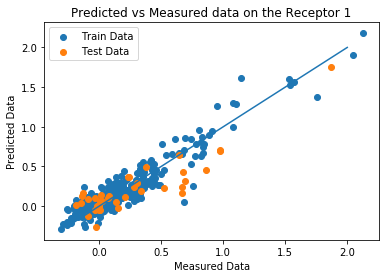

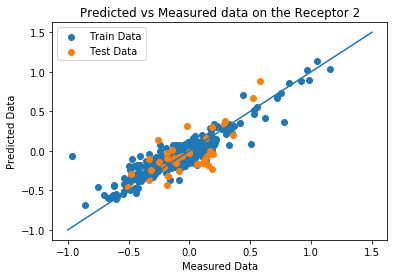

In [96]:

plt.scatter(y_train[:,0].cpu().detach().numpy(),y_pre[:,0].cpu().detach().numpy(),label='Train Data')
plt.scatter(y_test[:,0].cpu().detach().numpy(),y_val[:,0].cpu().detach().numpy(),label='Test Data')
plt.legend()
plt.xlabel('Measured Data')
plt.ylabel('Predicted Data')
plt.plot ([-0.25,2],[-0.25,2])
plt.title('Predicted vs Measured data on the Receptor 1')
plt.savefig('Receptor_1_Combined.png')
plt.show()


plt.scatter(y_train[:,1].cpu().detach().numpy(),y_pre[:,1].cpu().detach().numpy(),label='Train Data')
plt.scatter(y_test[:,1].cpu().detach().numpy(),y_val[:,1].cpu().detach().numpy(),label='Test Data')
plt.xlabel('Measured Data')
plt.ylabel('Predicted Data')
plt.plot ([-1,1.5],[-1,1.5])
plt.title('Predicted vs Measured data on the Receptor 2')
plt.legend()
plt.savefig('Receptor_2_Combined.png')
plt.show()

In [ ]:
already_existing={key: 1 for key in combi['Sequence']}

new_pep=[]
start=time.time()
KCFutil.random_walk2(new_pep,KCFutil.peptide(combi['Sequence'][0]),n=10, m=10000000, old_pep_dict=already_existing)
print('Time used for library generation {:.1f}s'.format(time.time()-start))

In [ ]:
x_new=torch.empty((len(new_pep),31,5))
y_new=torch.empty((len(new_pep),2))

for n,pep in  enumerate(new_pep):
    x_new[n]=torch.FloatTensor(pep.zscale5mat)



x_new=get_variable(x_new)
y_new=get_variable(y_new)

In [ ]:
y_new=net(x_new)

In [ ]:
plate1={}
j=0
for i in range(len(y_new)):
    if y_new[i][1]<-0.87:
        j+=1
        plate1[new_pep[i].sequence]=new_pep[i]
        
print (j)

In [ ]:
j=0
for i in range(len(y_new)):
    if y_new[i][0]<-0.70:
        j+=1
        plate1[new_pep[i].sequence]=new_pep[i]
        
print (j)
print (len(plate1))

In [ ]:
j=0
for i in range(len(y_new)):
    if (y_new[i][0]>0.50) and (y_new[i][0]<1.50):
        j+=1
        plate1[new_pep[i].sequence]=new_pep[i]
        if j==50:
            break
        
print (j)
print (len(plate1))

j=0
for i in range(len(y_new)):
    if (y_new[i][1]>0.50) and (y_new[i][1]<1.50):
        j+=1
        plate1[new_pep[i].sequence]=new_pep[i]
        if len(plate1)==160:
            break
        
print (j)
print (len(plate1))

In [ ]:
plate=[plate1[i] for i in plate1]
KCFutil.write_lib(plate, row2='S R T H R H S M E I R T P D I N P A W Y A S R G I R P V G R F', n=160)